# Introduction

This script is to test two nonlinear methods: xgboost and random forest. 

Todo list:

- set `y = EV/ebitda` and remove `t_ev` and `ebitda` columns from data
- log-tranform
- filling the missing data
- tune the parameter using 5-fold crossvalidation, excluding the 20 companies Derek selected
- fit the selected model with all the data (excluding those 20 companies) and report MSE for 20 companies


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from get_data import *

# SciKit Learn Modules
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Load raw data 

Take a look at t_ev/ebitda distribution, then decide whether doing log transformation on it or not

In [2]:
industrials_df_col_names = [
	't_ev',
	't_rev',
	'ebitda',
	'ebitda_margin',
	't_ev/t_rev',
	't_ev/ebitda',
	'est_ann_rev_gr_minus_1yr_minus_capiq',
	'est_ann_ebitda_gr_minus_1yr_minus_capiq',
	't_rev_1yr_growth',
	'ebitda_1yr_growth',
	't_rev_3_yr_cagr',
	'ebitda_3yr_cagr',
	't_rev_5yr_cagr',
	'ebitda_5yr_cagr',
	'return_on_assets',
	'return_on_equity',
	'capex_as_percent_rev',
	'ebitda/interest_exp',
	't_debt/cap_percent',
	't_debt/equity_percent'
	]

# Load Raw Data
raw_data_arrays         = get_raw_data()
raw_industrials_array   = np.split(raw_data_arrays[2], [1], axis=1)
raw_industrials_array_x = raw_industrials_array[1]
raw_industrials_array_y = raw_industrials_array[0]
raw_industrials_df      = pd.DataFrame( raw_data_arrays[2], columns=industrials_df_col_names )

# Load Standardized Data
std_data_arrays         = get_standardized_data()
std_industrials_array   = np.split(std_data_arrays[2], [1], axis=1)
std_industrials_array_x = std_industrials_array[1]
std_industrials_array_y = std_industrials_array[0]
std_industrials_df      = pd.DataFrame( std_data_arrays[2], columns=industrials_df_col_names )

In [3]:
raw_industrials_df.head()

,t_ev,t_rev,ebitda,ebitda_margin,t_ev/t_rev,t_ev/ebitda,est_ann_rev_gr_minus_1yr_minus_capiq,est_ann_ebitda_gr_minus_1yr_minus_capiq,t_rev_1yr_growth,ebitda_1yr_growth,t_rev_3_yr_cagr,ebitda_3yr_cagr,t_rev_5yr_cagr,ebitda_5yr_cagr,return_on_assets,return_on_equity,capex_as_percent_rev,ebitda/interest_exp,t_debt/cap_percent,t_debt/equity_percent
0,117144.9,30109.0,8676.3,28.80,3.890,13.5,1.06,2.79,-0.545,2.14,-0.83,2.580,0.334,3.20,13.80,45.80,4.720,43.60,53.00,112.60
1,7892.2,2627.2,517.5,19.70,3.000,15.3,6.32,14.80,4.090,20.90,7.43,19.200,10.400,25.50,10.40,22.00,2.870,72.90,14.70,17.30
2,1702.2,389.5,94.4,24.20,4.370,18.0,10.10,16.10,12.500,17.70,6.14,11.100,7.720,18.80,19.90,27.20,5.850,9.64,42.95,71.55
3,1243.0,1673.0,121.4,7.26,0.743,10.2,4.76,22.40,3.650,164.50,-5.18,-12.000,-2.650,-9.55,3.01,5.29,5.320,22.50,14.60,17.10
4,2481.2,5144.7,163.7,3.18,0.482,14.5,3.25,13.40,5.040,10.70,5.13,-0.203,3.910,-1.37,3.01,6.29,0.855,15.70,21.60,27.50


In [4]:
raw_industrials_df.t_ev/raw_industrials_df.t_rev

0       3.890694
1       3.004035
2       4.370218
3       0.742977
4       0.482283
5       1.092747
6       1.359820
7       0.976917
8       1.739596
9       2.971050
10      2.987520
11      1.496318
12      0.847073
13      0.529338
14      0.850422
15      5.741667
16     19.018979
17      0.879995
18      0.883469
19      1.856614
20      1.105592
21      1.702628
22      2.402795
23      2.345003
24      1.065037
25      4.113436
26      1.585435
27      2.738770
28      0.745851
29      1.014915
         ...    
443     6.909183
444     0.210588
445     0.186386
446     0.875604
447     2.612475
448     0.398820
449     2.263804
450     0.163632
451     1.082851
452     1.572989
453     0.557470
454     5.965398
455     3.030788
456     1.255717
457     1.764756
458     1.034495
459     1.526398
460     0.627931
461     2.228958
462     2.652309
463     0.550119
464     0.965027
465     4.992806
466     2.428720
467     7.552448
468     0.312579
469     1.260401
470     0.7187

In [5]:
std_industrials_df.head()

,t_ev,t_rev,ebitda,ebitda_margin,t_ev/t_rev,t_ev/ebitda,est_ann_rev_gr_minus_1yr_minus_capiq,est_ann_ebitda_gr_minus_1yr_minus_capiq,t_rev_1yr_growth,ebitda_1yr_growth,t_rev_3_yr_cagr,ebitda_3yr_cagr,t_rev_5yr_cagr,ebitda_5yr_cagr,return_on_assets,return_on_equity,capex_as_percent_rev,ebitda/interest_exp,t_debt/cap_percent,t_debt/equity_percent
0,4.535051,2.607147,5.202611,1.357549,1.633461,-0.020155,-0.089515,0.000000,-0.203587,-0.124874,-0.153001,-0.216283,-0.432096,-0.275069,1.623341,0.091535,-0.089412,4.724170e-01,0.221289,-1.315100e-01
1,0.041547,-0.111344,-0.035581,0.511802,0.988805,0.083611,0.248341,0.261897,-0.077531,0.022595,-0.030872,0.305456,0.271309,0.969670,0.943048,0.057141,-0.200292,1.167462e+00,-1.038116,-3.283892e-01
2,-0.213044,-0.332696,-0.307223,0.930029,1.981141,0.239261,0.491134,0.297772,0.151194,-0.002559,-0.049945,0.051179,0.084033,0.595690,2.843868,0.064655,-0.021684,-8.427634e-17,0.000000,-5.871610e-17
3,-0.231931,-0.205733,-0.289889,-0.644362,-0.646015,-0.210394,0.148140,0.471626,-0.089497,1.151410,-0.217319,-0.673982,-0.640615,-0.986748,-0.535590,0.032993,-0.053450,-2.811047e-02,-1.041404,-3.288024e-01
4,-0.181004,0.137686,-0.262731,-1.023554,-0.835065,0.037493,0.051151,0.223262,-0.051694,-0.057585,-0.064879,-0.303648,-0.182207,-0.530157,-0.535590,0.034438,-0.321063,-1.894179e-01,-0.811226,-3.073172e-01


In [6]:
std_industrials_df['t_ev/ebitda'] = std_industrials_df.t_ev/std_industrials_df.ebitda
std_industrials_df.head()

,t_ev,t_rev,ebitda,ebitda_margin,t_ev/t_rev,t_ev/ebitda,est_ann_rev_gr_minus_1yr_minus_capiq,est_ann_ebitda_gr_minus_1yr_minus_capiq,t_rev_1yr_growth,ebitda_1yr_growth,t_rev_3_yr_cagr,ebitda_3yr_cagr,t_rev_5yr_cagr,ebitda_5yr_cagr,return_on_assets,return_on_equity,capex_as_percent_rev,ebitda/interest_exp,t_debt/cap_percent,t_debt/equity_percent
0,4.535051,2.607147,5.202611,1.357549,1.633461,0.871688,-0.089515,0.000000,-0.203587,-0.124874,-0.153001,-0.216283,-0.432096,-0.275069,1.623341,0.091535,-0.089412,4.724170e-01,0.221289,-1.315100e-01
1,0.041547,-0.111344,-0.035581,0.511802,0.988805,-1.167694,0.248341,0.261897,-0.077531,0.022595,-0.030872,0.305456,0.271309,0.969670,0.943048,0.057141,-0.200292,1.167462e+00,-1.038116,-3.283892e-01
2,-0.213044,-0.332696,-0.307223,0.930029,1.981141,0.693449,0.491134,0.297772,0.151194,-0.002559,-0.049945,0.051179,0.084033,0.595690,2.843868,0.064655,-0.021684,-8.427634e-17,0.000000,-5.871610e-17
3,-0.231931,-0.205733,-0.289889,-0.644362,-0.646015,0.800068,0.148140,0.471626,-0.089497,1.151410,-0.217319,-0.673982,-0.640615,-0.986748,-0.535590,0.032993,-0.053450,-2.811047e-02,-1.041404,-3.288024e-01
4,-0.181004,0.137686,-0.262731,-1.023554,-0.835065,0.688933,0.051151,0.223262,-0.051694,-0.057585,-0.064879,-0.303648,-0.182207,-0.530157,-0.535590,0.034438,-0.321063,-1.894179e-01,-0.811226,-3.073172e-01


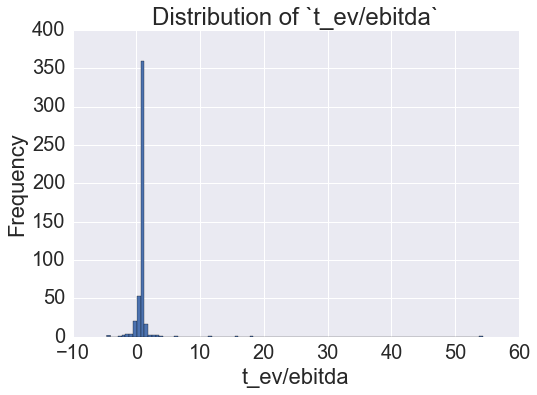

In [7]:
## distributions of `t_ev/ebitda`
sns.set(font_scale=2)
std_industrials_df['t_ev/ebitda'].plot('hist', bins=100)
plt.title('Distribution of `t_ev/ebitda`')
plt.xlabel('t_ev/ebitda')

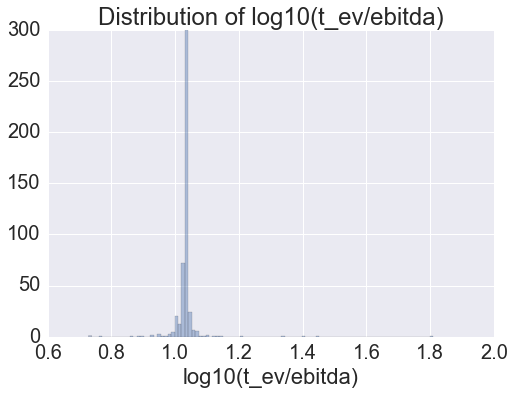

In [28]:
# distribution after log-transform
log_tev_ebitda = np.log10(std_industrials_df['t_ev/ebitda']+10)
sns.set(font_scale=2)
sns.distplot(log_tev_ebitda, kde=False, bins=100)
plt.title('Distribution of log10(t_ev/ebitda)')
plt.xlabel('log10(t_ev/ebitda)')

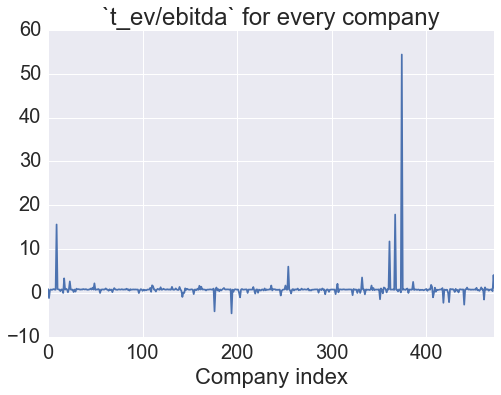

In [14]:
# `t_ev/ebitda` for each company
sns.set(font_scale=2)
std_industrials_df['t_ev/ebitda'].plot()
plt.title('`t_ev/ebitda` for every company')
plt.xlabel('Company index')

In [ ]:
# Functions to Perform Log10 Operation on Specific Feature Vectors 
features_to_transform = [0, 1, 2, 16, 17, 18, 19]

def log_basis( feature_vector ):
    return np.log10( feature_vector )

def log_transform_features(feature_matrix, features_to_transform):
    transformed_features  = []
    split_features = np.split( feature_matrix, feature_matrix.shape[1], axis=1 )
    for feature_num in list(range(len( split_features ))):
        feature = split_features[ feature_num ]
        if feature_num in features_to_transform:
            feature = log_basis( feature )
        transformed_features.append( feature )
    concat_features_array = np.concatenate( transformed_features, axis=1 )
    concat_features_array = scale(mean_fill_nan_entries( concat_features_array, is_df=False ))
    return concat_features_array